# Multi-Task Hierarchical Modeling
In multi-task hierarchical modeling, there is an explicit dependency structure between the tasks. The output of one task may be used as input (or conditioning context) for another.

Example Hierarchies:

  * Predict hatespeech first, then condition directness, target, etc., on that prediction.

  * Predict target, then use it to inform group, because groups are nested under targets.

                 [Transformer]
                      ↓
                 [hate_head]
                      ↓
           [directness | hate]
                      ↓
        [target | directness, hate]
                      ↓
        [group | target, directness, hate]


Reasons we're exploring hierarchical modeling:
- tasks are casually dependent
- the data is imbalanced and need strong signals from simpler tasks

In [1]:
!pip install -q evaluate torchinfo bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.8 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel
import pandas as pd

import numpy as np
from datasets import Dataset
import evaluate
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from torchinfo import summary
import torch
from transformers import BertTokenizer, BertForSequenceClassification, BitsAndBytesConfig
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [24]:
import warnings

In [25]:
# Suppress warnings like encoder_attention_mask future warning
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#load dataset
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP_Datasci266/final_project/combined_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP_Datasci266/final_project/combined_test.csv')
val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP_Datasci266/final_project/combined_val.csv')

In [5]:
train_df = train_df.dropna(subset=["text_cleaned"])
test_df = test_df.dropna(subset=["text_cleaned"])
val_df = val_df.dropna(subset=["text_cleaned"])

In [6]:
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [7]:
#convert to HuggingFace dataset / format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
val_dataset = Dataset.from_pandas(val_df)

In [8]:
sentiment_cols = [col for col in train_df.columns if col.startswith('sentiment_')]
sentiment_cols

['sentiment_anger',
 'sentiment_confusion',
 'sentiment_disgust',
 'sentiment_fear',
 'sentiment_indifference',
 'sentiment_normal',
 'sentiment_sadness',
 'sentiment_shock']

In [12]:
# Tokenizer
from transformers import AutoModel, AutoTokenizer

model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [14]:
class HierarchicalDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.sentiment_cols = [col for col in df.columns if col.startswith('sentiment_')]
        print(f"Detected sentiment columns: {self.sentiment_cols}")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        encoding = self.tokenizer(row['text_cleaned'], padding='max_length', truncation=True, max_length=self.max_len, return_tensors='pt')

        hate = torch.tensor(row['hatespeech'], dtype=torch.float)
        directness = torch.tensor(row['directness_label'], dtype=torch.long)
        target = torch.tensor(row['target_label'], dtype=torch.long)
        group = torch.tensor(row['group_label'], dtype=torch.long)
        sentiments = torch.tensor(row[self.sentiment_cols].to_numpy(dtype='int64'), dtype=torch.float)


        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'hate': hate,
            'directness': directness,
            'target': target,
            'group': group,
            'sentiments': sentiments,
        }


# Hierarchical Multi-Task Model

In [15]:
import torch.nn as nn

class HierarchicalMultiTaskModel(nn.Module):
    def __init__(self, base_model, hidden_dim=768, num_groups=17, num_targets=4, num_directness=3, sentiment_size=8):
        super().__init__()
        self.encoder = base_model

        self.hate_head = nn.Linear(hidden_dim, 1)
        self.directness_head = nn.Linear(hidden_dim + 1, 3)
        self.target_head = nn.Linear(hidden_dim + 3, 7)
        self.group_head = nn.Linear(hidden_dim + 7, 17)
        self.sentiment_head = nn.Linear(hidden_dim, 8)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token

        hate_logits = self.hate_head(pooled_output)
        directness_logits = self.directness_head(torch.cat([pooled_output, torch.sigmoid(hate_logits)], dim=1))
        target_logits = self.target_head(torch.cat([pooled_output, torch.softmax(directness_logits, dim=1)], dim=1))
        group_logits = self.group_head(torch.cat([pooled_output, torch.softmax(target_logits, dim=1)], dim=1))
        sentiment_logits = self.sentiment_head(pooled_output)

        return {
            'hate': hate_logits.squeeze(-1),
            'directness': directness_logits,
            'target': target_logits,
            'group': group_logits,
            'sentiments': sentiment_logits
        }


# Loss Function

In [16]:
train_dataset = HierarchicalDataset(train_df, tokenizer, max_len=128) #, sentiment_cols=sentiment_cols)
val_dataset =HierarchicalDataset(val_df, tokenizer, max_len=128)#, sentiment_cols=sentiment_cols)
test_dataset = HierarchicalDataset(test_df, tokenizer, max_len=128) #, sentiment_cols=sentiment_cols)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

Detected sentiment columns: ['sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference', 'sentiment_normal', 'sentiment_sadness', 'sentiment_shock']
Detected sentiment columns: ['sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference', 'sentiment_normal', 'sentiment_sadness', 'sentiment_shock']
Detected sentiment columns: ['sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference', 'sentiment_normal', 'sentiment_sadness', 'sentiment_shock']


In [22]:
from torch.optim import AdamW
from tqdm import tqdm
# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HierarchicalMultiTaskModel(base_model).to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)


In [18]:
def compute_loss(outputs, labels):
    loss_fn_bce = nn.BCEWithLogitsLoss()
    loss_fn_ce = nn.CrossEntropyLoss()

    hate_loss = loss_fn_bce(outputs['hate'], labels['hate'])
    directness_loss = loss_fn_ce(outputs['directness'], labels['directness'])
    target_loss = loss_fn_ce(outputs['target'], labels['target'])
    group_loss = loss_fn_ce(outputs['group'], labels['group'])
    sentiments_loss = loss_fn_bce(outputs['sentiments'], labels['sentiments'])

    total_loss = hate_loss + directness_loss + target_loss + group_loss + sentiments_loss
    return total_loss


# Evaluate Function

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def evaluate1(model, dataloader):
    model.eval()
    hate_preds, hate_labels = [], []
    dir_preds, dir_labels = [], []
    tgt_preds, tgt_labels = [], []
    grp_preds, grp_labels = [], []
    sent_preds, sent_labels = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Binary hate
            preds = (torch.sigmoid(outputs['hate']) > 0.5).int().cpu()
            labels = batch['hate'].int()
            hate_preds.extend(preds.numpy())
            hate_labels.extend(labels.numpy())

            # Multi-class
            for task in ['directness', 'target', 'group']:
                preds = torch.argmax(outputs[task], dim=1).cpu()
                labels = batch[task]
                if task == 'directness':
                    dir_preds.extend(preds.numpy())
                    dir_labels.extend(labels.numpy())
                elif task == 'target':
                    tgt_preds.extend(preds.numpy())
                    tgt_labels.extend(labels.numpy())
                else:
                    grp_preds.extend(preds.numpy())
                    grp_labels.extend(labels.numpy())

            # Sentiment: multilabel
            sent_out = (torch.sigmoid(outputs['sentiments']) > 0.5).int().cpu()
            sent_lbl = batch['sentiments'].int()
            sent_preds.append(sent_out.numpy())
            sent_labels.append(sent_lbl.numpy())

    # Stack sentiment arrays
    sent_preds = np.vstack(sent_preds)
    sent_labels = np.vstack(sent_labels)

    print("\nHATE (Binary):")
    print("  Accuracy:", accuracy_score(hate_labels, hate_preds))
    print("  Precision (micro):", precision_score(hate_labels, hate_preds, average='micro'))
    print("  Recall (micro):", recall_score(hate_labels, hate_preds, average='micro'))
    print("  F1 Score (micro):", f1_score(hate_labels, hate_preds, average='micro'))

    print("\nDIRECTNESS (Multi-Class):")
    print("  Accuracy:", accuracy_score(dir_labels, dir_preds))
    print("  Precision (micro):", precision_score(dir_labels, dir_preds, average='micro'))
    print("  Recall (micro):", recall_score(dir_labels, dir_preds, average='micro'))
    print("  F1 Score (micro):", f1_score(dir_labels, dir_preds, average='micro'))

    print("\nTARGET (Multi-Class):")
    print("  Accuracy:", accuracy_score(tgt_labels, tgt_preds))
    print("  Precision (micro):", precision_score(tgt_labels, tgt_preds, average='micro'))
    print("  Recall (micro):", recall_score(tgt_labels, tgt_preds, average='micro'))
    print("  F1 Score (micro):", f1_score(tgt_labels, tgt_preds, average='micro'))

    print("\nGROUP (Multi-Class):")
    print("  Accuracy:", accuracy_score(grp_labels, grp_preds))
    print("  Precision (micro):", precision_score(grp_labels, grp_preds, average='micro'))
    print("  Recall (micro):", recall_score(grp_labels, grp_preds, average='micro'))
    print("  F1 Score (micro):", f1_score(grp_labels, grp_preds, average='micro'))

    print("\nSENTIMENTS (Multi-Label, 8 classes):")
    print("  Precision (micro):", precision_score(sent_labels, sent_preds, average='micro'))
    print("  Recall (micro):", recall_score(sent_labels, sent_preds, average='micro'))
    print("  F1 Score (micro):", f1_score(sent_labels, sent_preds, average='micro'))

           # Convert all tasks to flat binary comparisons
    flat_preds = np.concatenate([
        np.array(hate_preds).reshape(-1),
        np.array(dir_preds).reshape(-1),
        np.array(tgt_preds).reshape(-1),
        np.array(grp_preds).reshape(-1),
        sent_preds.flatten()
    ])

    flat_labels = np.concatenate([
        np.array(hate_labels).reshape(-1),
        np.array(dir_labels).reshape(-1),
        np.array(tgt_labels).reshape(-1),
        np.array(grp_labels).reshape(-1),
        sent_labels.flatten()
    ])

    print("\nOVERALL (All Tasks Combined - Micro Average):")
    print("  Precision (micro):", precision_score(flat_labels, flat_preds, average='micro', zero_division=0))
    print("  Recall (micro):", recall_score(flat_labels, flat_preds, average='micro', zero_division=0))
    print("  F1 Score (micro):", f1_score(flat_labels, flat_preds, average='micro', zero_division=0))


# Model Training

In [20]:
def train(model, train_loader, val_loader, epochs=3):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for batch in loop:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            labels = {
                'hate': batch['hate'].to(device),
                'directness': batch['directness'].to(device),
                'target': batch['target'].to(device),
                'group': batch['group'].to(device),
                'sentiments': batch['sentiments'].to(device)
            }

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = compute_loss(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = total_loss / len(train_loader)
        print(f"\nEpoch {epoch+1} Training Loss: {avg_train_loss:.4f}")

        #evaluate1(model, val_loader)


In [26]:
train(model, train_loader, val_loader, epochs=3)

Epoch 1/3: 100%|██████████| 960/960 [11:31<00:00,  1.39it/s, loss=2.61]



Epoch 1 Training Loss: 2.9529


Epoch 2/3: 100%|██████████| 960/960 [11:33<00:00,  1.38it/s, loss=1.31]



Epoch 2 Training Loss: 2.1017


Epoch 3/3: 100%|██████████| 960/960 [11:33<00:00,  1.38it/s, loss=1.88]


Epoch 3 Training Loss: 1.9523


In [ ]:
train(model, train_loader, val_loader, epochs=3)

Epoch 1/3:   0%|          | 0/960 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 1/3:   0%|          | 1/960 [00:02<32:22,  2.03s/it, loss=7.89]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 1/3:   0%|          | 2/960 [00:02<19:40,  1.23s/it, loss=7.76]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 1/3:   0%|          | 3/960 [00:03<15:30,  1.03it/s, loss=7.61]/u


Epoch 1 Training Loss: 3.0104


Epoch 2/3:   0%|          | 0/960 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 2/3:   0%|          | 1/960 [00:00<12:10,  1.31it/s, loss=2.07]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 2/3:   0%|          | 2/960 [00:01<12:06,  1.32it/s, loss=1.73]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 2/3:   0%|          | 3/960 [00:02<11:58,  1.33it/s, loss=1.93]/u


Epoch 2 Training Loss: 2.1455


Epoch 3/3:   0%|          | 0/960 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 3/3:   0%|          | 1/960 [00:00<11:55,  1.34it/s, loss=1.84]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 3/3:   0%|          | 2/960 [00:01<11:59,  1.33it/s, loss=2.33]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 3/3:   0%|          | 3/960 [00:02<11:56,  1.34it/s, loss=1.44]/u


Epoch 3 Training Loss: 1.9997


In [ ]:
evaluate1(model, val_loader)

Evaluating:   0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   1%|          | 1/122 [00:00<00:44,  2.75it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   2%|▏         | 2/122 [00:00<00:32,  3.68it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   2%|▏         | 3/122 [00:00<00:29,  4.04it/s]/usr/local/lib/python3.11/dist-


HATE (Binary):
  Accuracy: 0.9525641025641025
  Precision (micro): 0.9525641025641025
  Recall (micro): 0.9525641025641025
  F1 Score (micro): 0.9525641025641025

DIRECTNESS (Multi-Class):
  Accuracy: 0.841025641025641
  Precision (micro): 0.841025641025641
  Recall (micro): 0.841025641025641
  F1 Score (micro): 0.841025641025641

TARGET (Multi-Class):
  Accuracy: 0.7971794871794872
  Precision (micro): 0.7971794871794872
  Recall (micro): 0.7971794871794872
  F1 Score (micro): 0.7971794871794872

GROUP (Multi-Class):
  Accuracy: 0.7333333333333333
  Precision (micro): 0.7333333333333333
  Recall (micro): 0.7333333333333333
  F1 Score (micro): 0.7333333333333333

SENTIMENTS (Multi-Label, 8 classes):
  Precision (micro): 0.6869020699252044
  Recall (micro): 0.5989686030638556
  F1 Score (micro): 0.6399286987522281

OVERALL (All Tasks Combined - Micro Average):
  Precision (micro): 0.8487179487179487
  Recall (micro): 0.8487179487179487
  F1 Score (micro): 0.8487179487179487


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import numpy as np
import warnings

# Suppress warnings like encoder_attention_mask future warning
warnings.filterwarnings("ignore", category=FutureWarning)

def generate_confusion_matrices_by_language(model, df, tokenizer, device, batch_size=8):
    model.eval()
    model.to(device)

    label_names = {
        'hate': ['Not Hate', 'Hate'],
        'directness': ['direct', 'indirect', 'normal'],
        'target': ["disability", "gender", "normal", "origin", "other", "religion", "sexual_orientation"],
        'group': ["african_descent", "arabs", "asians", "christian", "gay", "hispanics", "immigrants",
                  "indian/hindu", "individual", "jews", "left_wing_people", "muslims", "normal", "other",
                  "refugees", "special_needs", "women"],
        'sentiments': ['sentiment_anger','sentiment_confusion','sentiment_disgust','sentiment_fear',
                       'sentiment_indifference','sentiment_normal','sentiment_sadness','sentiment_shock']
    }

    language_map = {
        enc: lang for enc, lang in df[['language_encoded', 'language']].drop_duplicates().values
    }

    languages = df['language_encoded'].unique()

    for lang_code in languages:
        lang_name = language_map.get(lang_code, f"lang_{lang_code}")
        print(f"\n Language: {lang_name} (encoded: {lang_code})")

        lang_df = df[df['language_encoded'] == lang_code]
        if len(lang_df) == 0:
            print(f" No data for language {lang_name}. Skipping...")
            continue

        dataset = HierarchicalDataset(lang_df, tokenizer)
        loader = DataLoader(dataset, batch_size=batch_size)

        all_true = {k: [] for k in ['hate', 'directness', 'target', 'group', 'sentiments']}
        all_preds = {k: [] for k in ['hate', 'directness', 'target', 'group', 'sentiments']}

        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

            # HATE (binary)
            if 'hate' in outputs:
                true_hate = batch['hate'].detach().cpu().numpy()
                pred_hate = (torch.sigmoid(outputs['hate']).detach().cpu().numpy() > 0.5).astype(int)
                all_true['hate'].extend(true_hate)
                all_preds['hate'].extend(pred_hate)

            # DIRECTNESS, TARGET, GROUP (multiclass)
            for task in ['directness', 'target', 'group']:
                if task in outputs:
                    true_task = batch[task].detach().cpu().numpy()
                    pred_task = torch.argmax(outputs[task], dim=1).detach().cpu().numpy()
                    all_true[task].extend(true_task)
                    all_preds[task].extend(pred_task)

            # SENTIMENTS (multilabel)
            if 'sentiments' in outputs:
                true_sent = batch['sentiments'].detach().cpu().numpy()
                pred_sent = (torch.sigmoid(outputs['sentiments']).detach().cpu().numpy() > 0.5).astype(int)
                all_true['sentiments'].append(true_sent)
                all_preds['sentiments'].append(pred_sent)

        # Plot confusion matrices for single-label tasks
        for task in ['hate', 'directness', 'target', 'group']:
            if len(all_true[task]) == 0 or len(all_preds[task]) == 0:
                print(f" Skipping {task} for language {lang_name} due to no data.")
                continue
            labels = label_names[task]
            used_indices = sorted(set(all_true[task]) | set(all_preds[task]))
            used_labels = [labels[int(i)] for i in used_indices]
            cm = confusion_matrix(all_true[task], all_preds[task], labels=used_indices)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=used_labels)
            disp.plot(cmap='Blues')
            plt.title(f'{task.capitalize()} | Language: {lang_name}')
            # Rotate ticks based on task
            # if task == 'group':
            #     plt.xticks(rotation=90, fontsize=8)
            #     plt.yticks(rotation=0, fontsize=8)
            # else:
            #     plt.xticks(rotation=45)
            #     plt.yticks(rotation=45)
            plt.xticks(rotation=90)
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()


        # Plot confusion matrices for multilabel sentiments
        if len(all_true['sentiments']) > 0 and len(all_preds['sentiments']) > 0:
            true_sent_arr = np.vstack(all_true['sentiments'])
            pred_sent_arr = np.vstack(all_preds['sentiments'])

            for i, name in enumerate(label_names['sentiments']):
                cm = confusion_matrix(true_sent_arr[:, i], pred_sent_arr[:, i])
                disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Not {name}', name])
                disp.plot(cmap='Purples')
                plt.title(f'Sentiment: {name.replace("sentiment_", "").capitalize()} | Language: {lang_name}')
                plt.xticks(rotation=90)
                #plt.yticks(rotation=90)
                plt.tight_layout()
                plt.show()
        else:
            print(f"Skipping sentiments for language {lang_name} due to no data.")



 Language: french (encoded: 1)
Detected sentiment columns: ['sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference', 'sentiment_normal', 'sentiment_sadness', 'sentiment_shock']


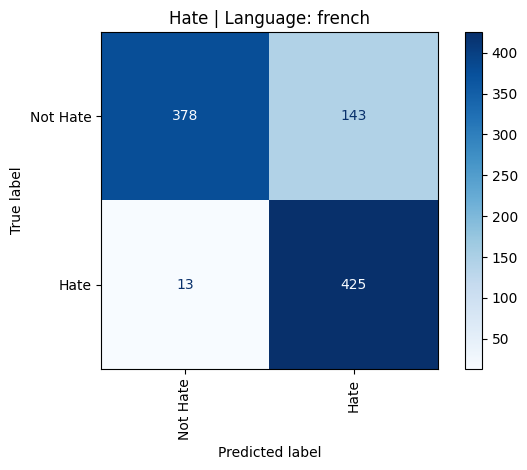

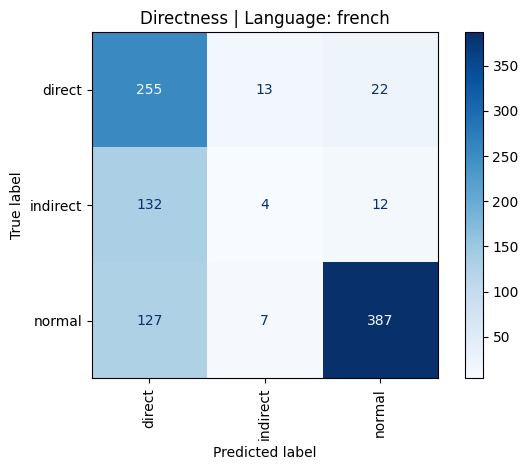

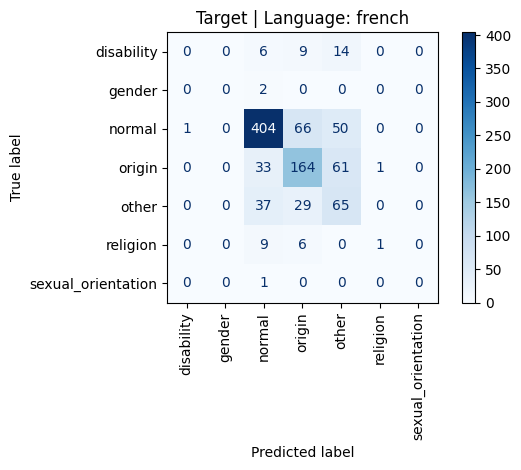

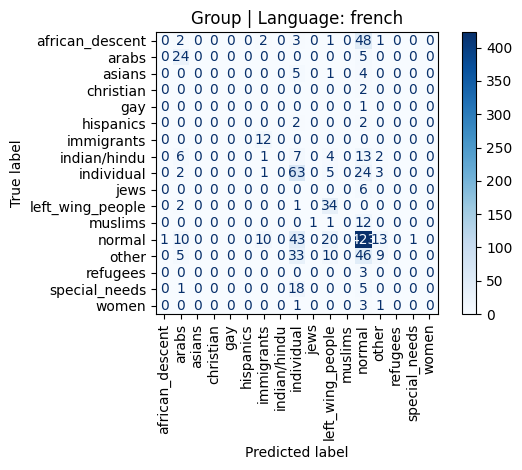

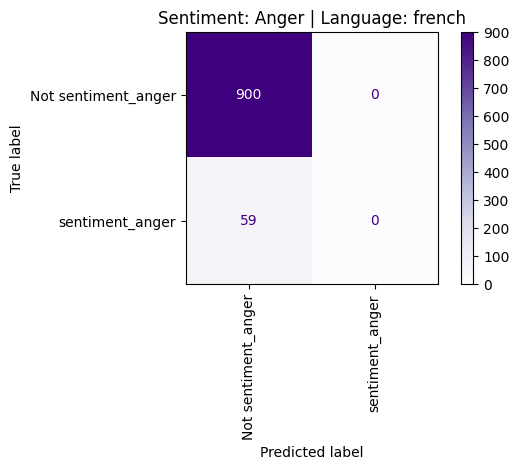

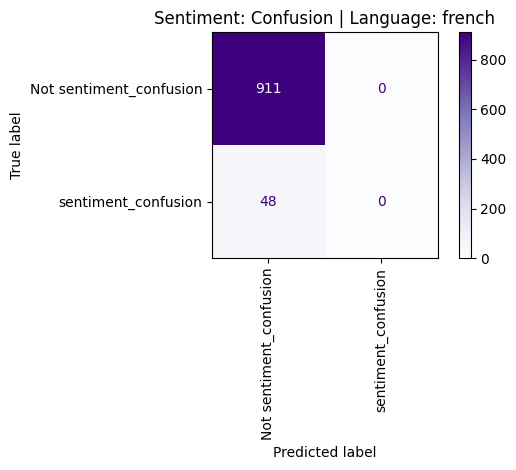

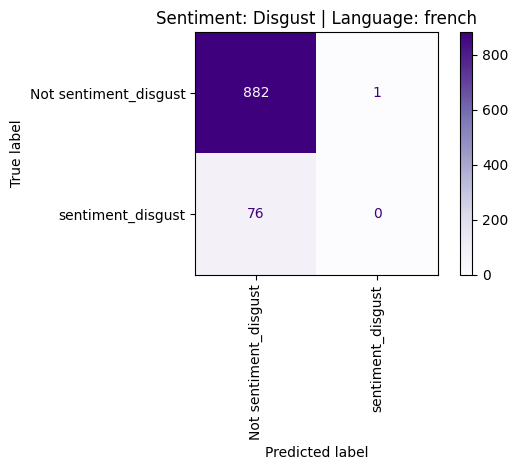

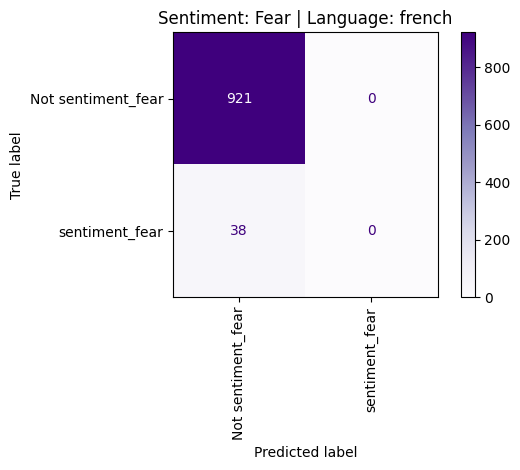

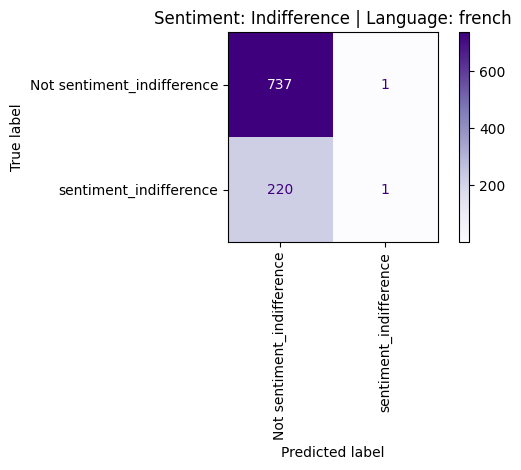

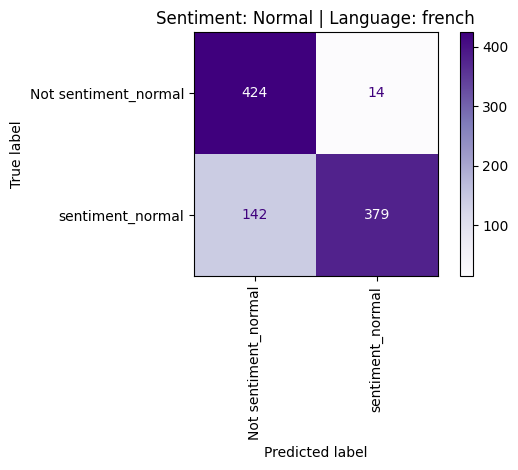

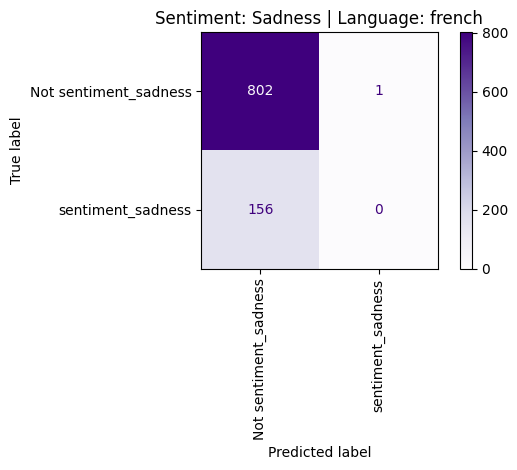

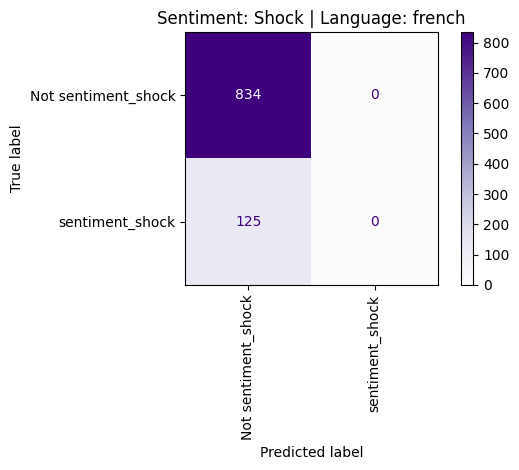


 Language: arabic (encoded: 2)
Detected sentiment columns: ['sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference', 'sentiment_normal', 'sentiment_sadness', 'sentiment_shock']


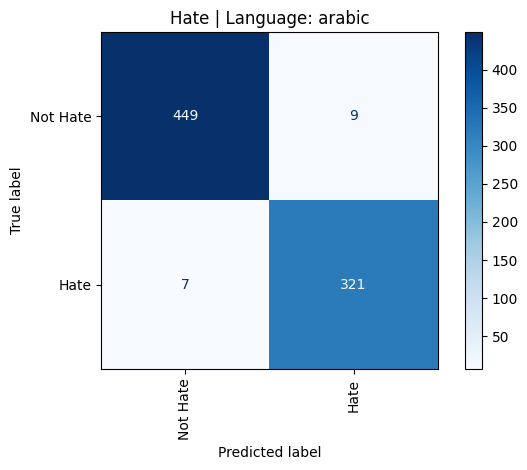

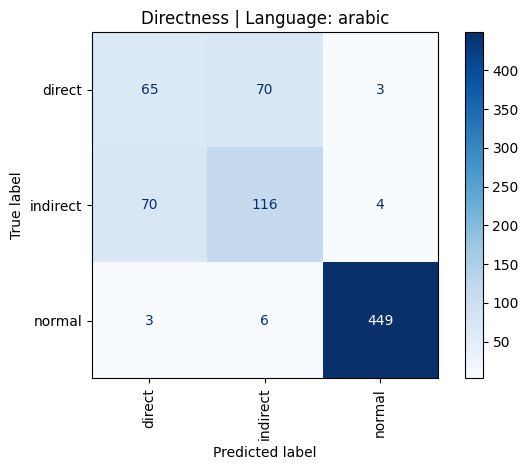

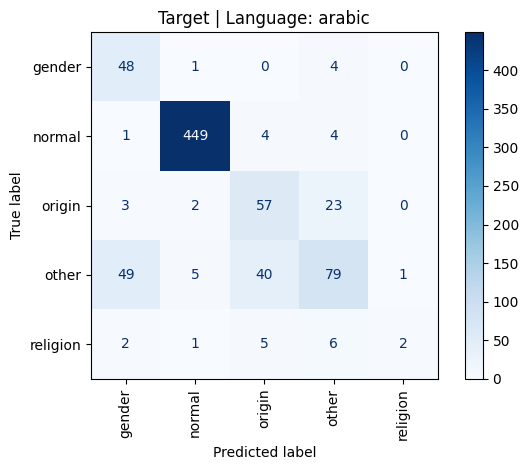

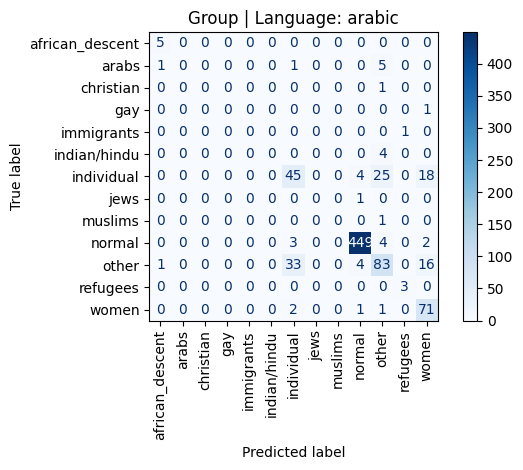

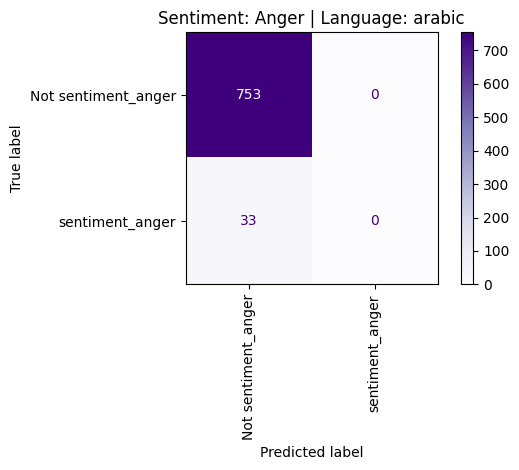

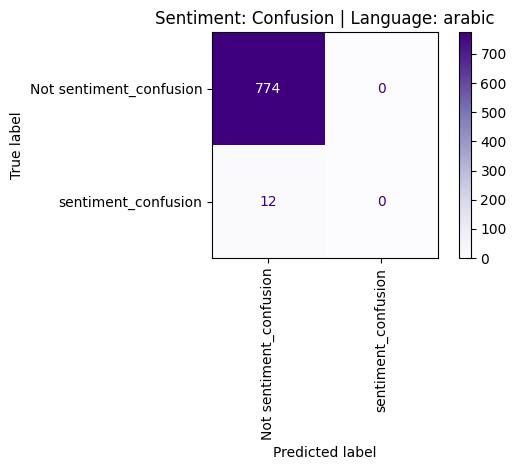

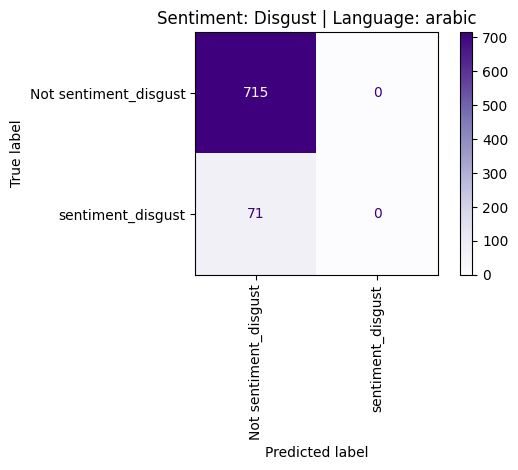

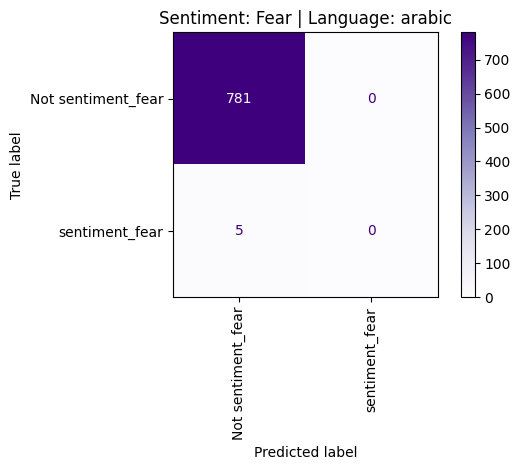

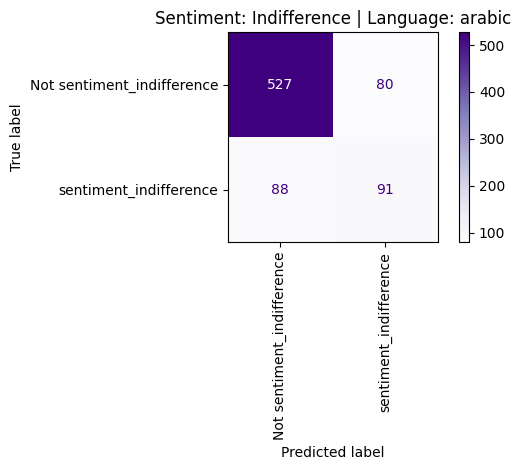

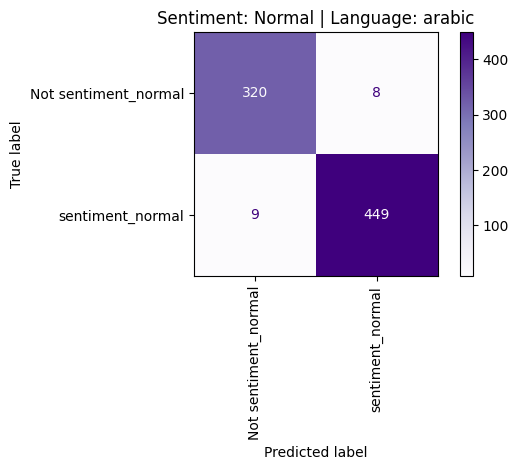

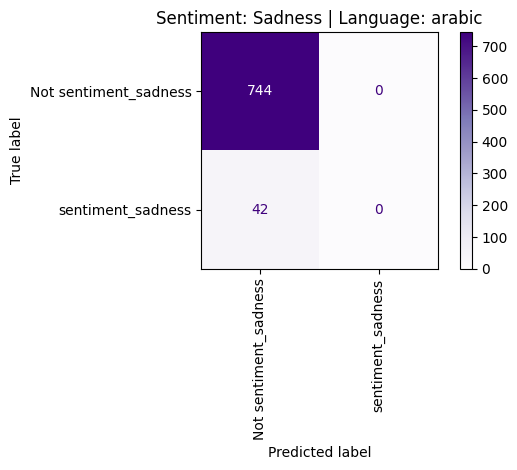

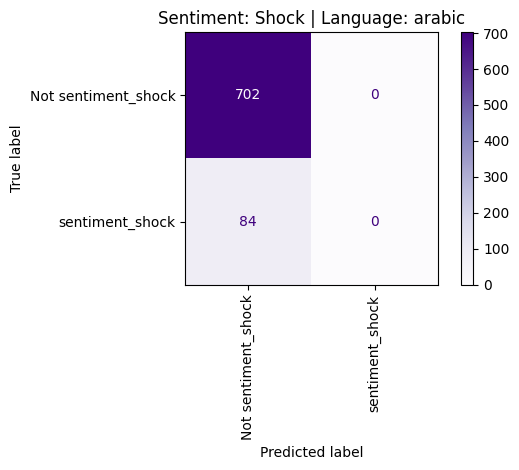


 Language: english (encoded: 0)
Detected sentiment columns: ['sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference', 'sentiment_normal', 'sentiment_sadness', 'sentiment_shock']


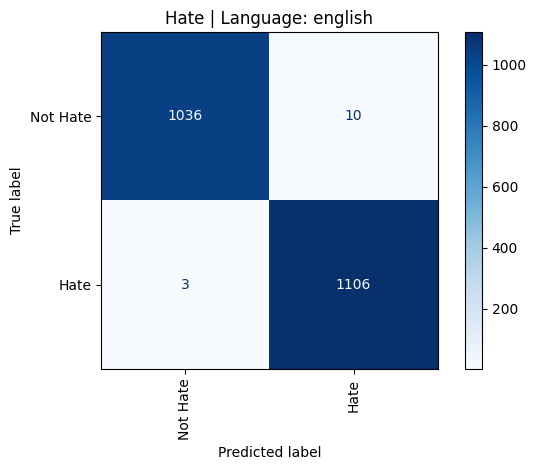

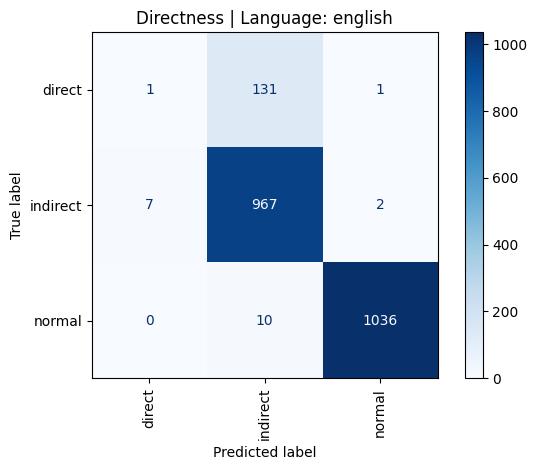

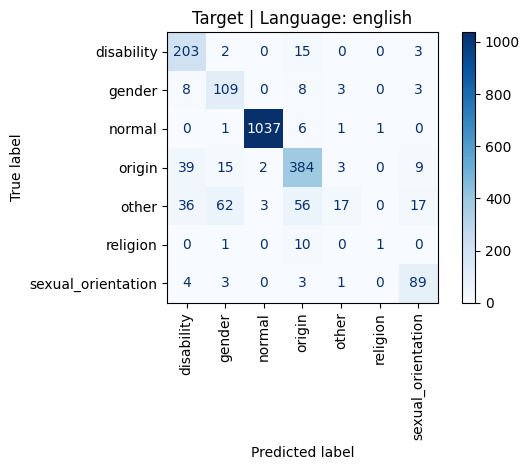

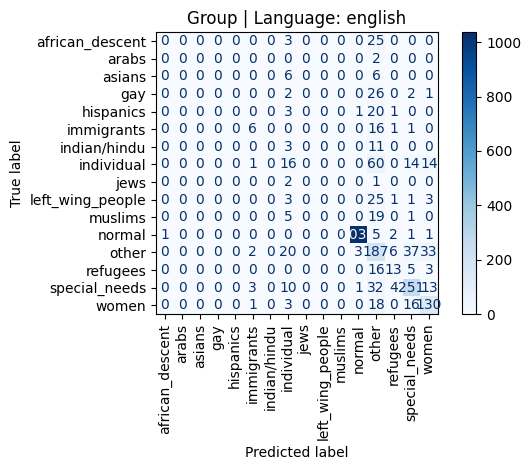

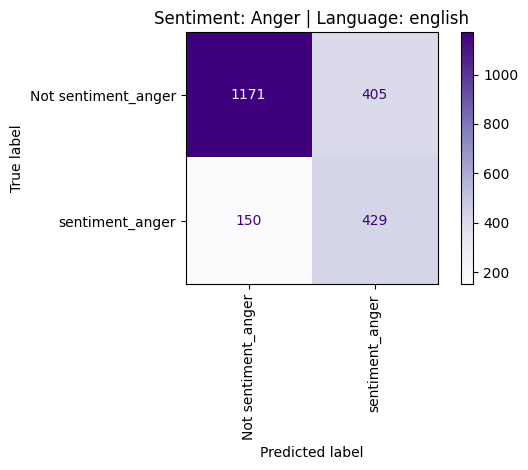

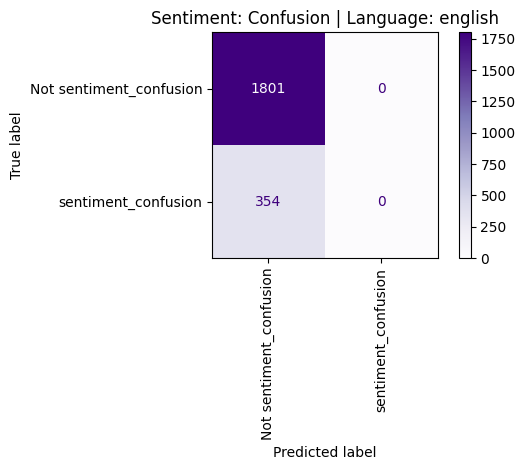

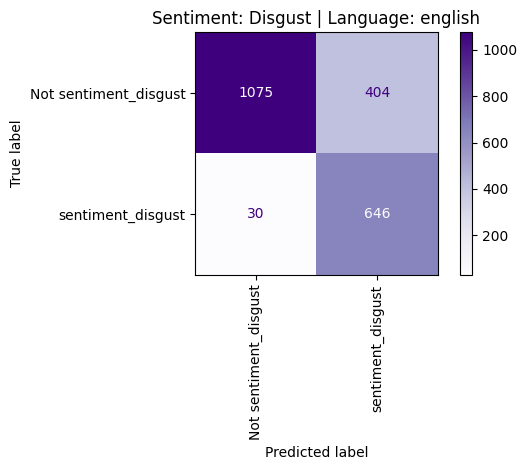

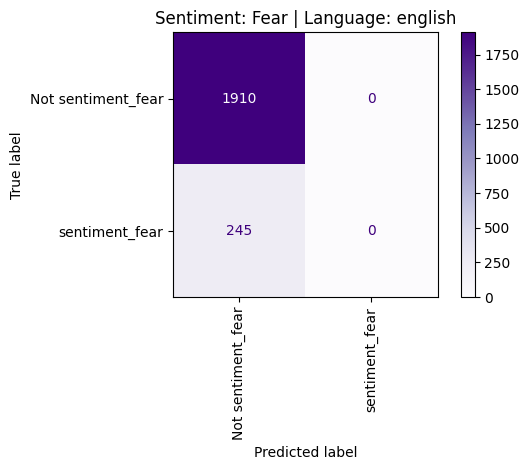

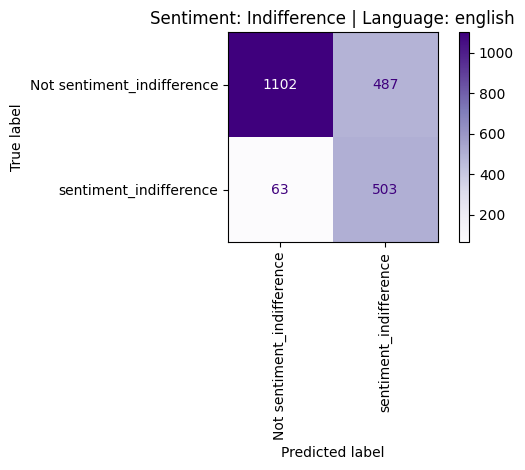

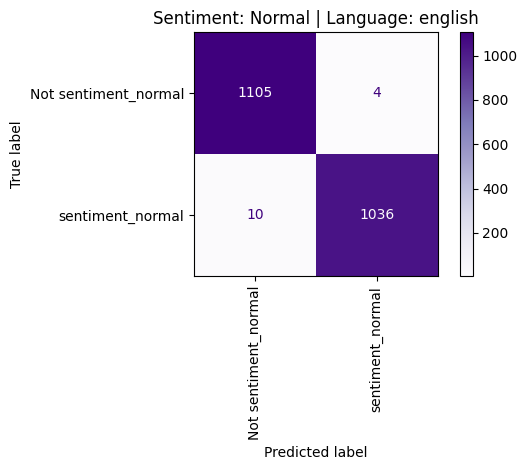

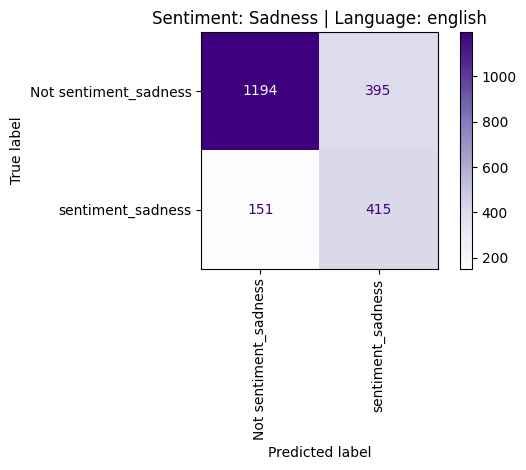

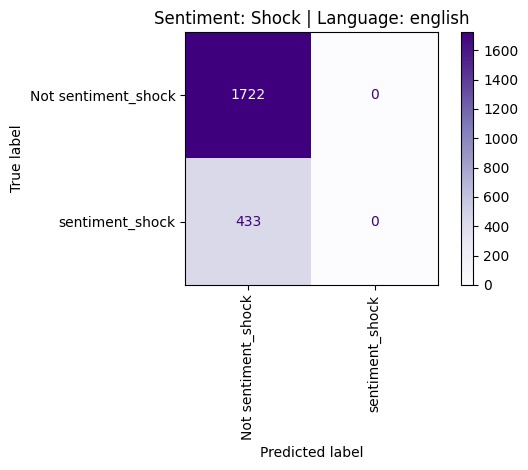

In [ ]:
generate_confusion_matrices_by_language(model, val_df, tokenizer, device)

# LIME

In [27]:
!pip install -q lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [28]:
from lime.lime_text import LimeTextExplainer
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [29]:
label_names = {
    'hate': ['Not Hate', 'Hate'],
    'directness': ['direct', 'indirect', 'normal'],
    'target': ["disability", "gender", "normal", "origin", "other", "religion", "sexual_orientation"],
    'group': ["african_descent", "arabs", "asians", "christian", "gay", "hispanics", "immigrants",
              "indian/hindu", "individual", "jews", "left_wing_people", "muslims", "normal", "other",
              "refugees", "special_needs", "women"],
    'sentiments': ['sentiment_anger','sentiment_confusion','sentiment_disgust','sentiment_fear',
                   'sentiment_indifference','sentiment_normal','sentiment_sadness','sentiment_shock']
}


In [30]:
from lime.lime_text import LimeTextExplainer
import torch
from torch.utils.data import DataLoader
import numpy as np

def run_lime_explanations(model, df, tokenizer, device, label_names, max_per_class=2):
    model.eval()
    model.to(device)

    # Mapping from model task keys to dataframe label columns
    task_to_df_col = {
        'hate': 'hatespeech',
        'directness': 'directness_label',
        'target': 'target_label',
        'group': 'group_label',
    }

    languages = df['language_encoded'].unique()
    languages = [0, 2]
    explainer = LimeTextExplainer()

    for lang_code in languages:
        lang_name = df[df['language_encoded'] == lang_code]['language'].iloc[0]
        print(f"\n=== LANGUAGE: {lang_name} ===")

        # Subset df by language
        lang_df = df[df['language_encoded'] == lang_code].reset_index(drop=True)

        # Prepare dataset and loader for the language
        dataset = HierarchicalDataset(lang_df, tokenizer)
        loader = DataLoader(dataset, batch_size=8)

        for task in ['hate', 'directness', 'target', 'group']:
            print(f"\n--- TASK: {task.upper()} ---")

            # Containers for examples: {class_label: {'correct': [texts], 'incorrect': [texts]}}
            examples = {cls_name: {'correct': [], 'incorrect': []} for cls_name in label_names[task]}

            # Go through data loader batches
            for batch_idx, batch in enumerate(loader):
                batch = {k: v.to(device) for k, v in batch.items()}
                texts = [lang_df.iloc[i]['text_cleaned'] for i in range(batch_idx*8, min((batch_idx+1)*8, len(lang_df)))]

                with torch.no_grad():
                    outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

                # Get true labels from batch according to dataframe column mapping
                df_col = task_to_df_col[task]
                true_labels = lang_df.iloc[batch_idx*8 : batch_idx*8 + len(texts)][df_col].values

                # Get predictions depending on task
                if task == 'hate':
                    # Binary sigmoid output; threshold at 0.5
                    probs = torch.sigmoid(outputs['hate']).cpu().numpy()
                    preds = (probs > 0.5).astype(int).flatten()
                else:
                    # Multi-class: argmax logits
                    preds = torch.argmax(outputs[task], dim=1).cpu().numpy()

                # For each example in batch, collect text by correctness
                for i, (text, true_label, pred_label) in enumerate(zip(texts, true_labels, preds)):
                    cls_name = label_names[task][int(true_label)]
                    correct = (true_label == pred_label)
                    cat = 'correct' if correct else 'incorrect'

                    # Limit number of examples stored per class/correctness
                    if len(examples[cls_name][cat]) < max_per_class:
                        examples[cls_name][cat].append(text)

            # Now explain examples using LIME
            for cls_name in examples:
                for correctness in ['correct', 'incorrect']:
                    ex_list = examples[cls_name][correctness]
                    if not ex_list:
                        continue
                    print(f"\nClass '{cls_name}' - {correctness} predictions (showing up to {max_per_class}):")

                    for example_text in ex_list:
                        print(f"\nText: {example_text[:200]}...")  # print first 200 chars

                        def predict_proba(texts):
                            model.eval()
                            enc = tokenizer(texts, return_tensors='pt', padding=True, truncation=True).to(device)
                            with torch.no_grad():
                                out = model(input_ids=enc['input_ids'], attention_mask=enc['attention_mask'])

                            # Prepare probs for LIME
                            if task == 'hate':
                                probs = torch.sigmoid(out['hate']).cpu().numpy()
                                # Return two class probs: [P(not hate), P(hate)]
                                return np.vstack([1 - probs.flatten(), probs.flatten()]).T
                            else:
                                logits = out[task].cpu().numpy()
                                # Softmax to probabilities
                                exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
                                probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)
                                return probs

                        lime_exp = explainer.explain_instance(example_text, predict_proba, num_features=10, labels=[label_names[task].index(cls_name)])

                        # Show top positive and negative features for the class
                        print("LIME Explanation (top features):")
                        for feat, weight in lime_exp.as_list(label=label_names[task].index(cls_name)):
                            print(f"{feat}: {weight:.3f}")


## [NOT RUNNING] English and Arabic LIME Results

In [31]:
run_lime_explanations(model, val_df, tokenizer, device, label_names)


=== LANGUAGE: english ===
Detected sentiment columns: ['sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference', 'sentiment_normal', 'sentiment_sadness', 'sentiment_shock']

--- TASK: HATE ---

Class 'Not Hate' - correct predictions (showing up to 2):

Text: @savannahx___ negative slopes aka a chart of my grades in math...
LIME Explanation (top features):
savannahx___: 0.000
slopes: 0.000
grades: 0.000
math: -0.000
of: 0.000
my: 0.000
in: 0.000
a: 0.000
negative: -0.000
chart: -0.000

Text: #cnbcsquawk #fucktrump #trump2020 Joe Kernen finally said something valuable when he said 'I KNOW, ORANGE MAN BAD' TRUMP IS DOG VOMIT https://t.co/kisE45leuc...


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.21 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.52 GiB is free. Process 11275 has 13.22 GiB memory in use. Of the allocated memory 9.87 GiB is allocated by PyTorch, and 3.22 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## French LIME Results

In [ ]:
run_lime_explanations(model, val_df, tokenizer, device, label_names)


=== LANGUAGE: french ===
Detected sentiment columns: ['sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference', 'sentiment_normal', 'sentiment_sadness', 'sentiment_shock']

--- TASK: HATE ---

Class 'Not Hate' - correct predictions (showing up to 2):

Text: Le #sexiste, anti #IVG #Avortement, #Liberticide qui pense que humain =/= animal ... LINK...
LIME Explanation (top features):
Avortement: -0.503
LINK: 0.264
Liberticide: 0.151
anti: 0.121
Le: 0.073
qui: 0.043
pense: 0.029
animal: 0.021
IVG: 0.014
que: 0.004

Text: ok...
LIME Explanation (top features):
ok: 0.328

Class 'Not Hate' - incorrect predictions (showing up to 2):

Text: un attarde pareil cest du jamais vu...
LIME Explanation (top features):
attarde: -0.604
un: -0.019
pareil: -0.009
cest: 0.009
du: 0.006
vu: -0.003
jamais: 0.002

Text: eh bin tu restes à oran!!! sale arabe que tu es...
LIME Explanation (top features):
arabe: -0.628
sale: 0.006
es: 0.003
à: 0.003
oran: 0.002
t

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.92 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.32 GiB is free. Process 7619 has 13.42 GiB memory in use. Of the allocated memory 9.38 GiB is allocated by PyTorch, and 3.91 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Showing 5 exampes per class

In [ ]:
run_lime_explanations(model, val_df, tokenizer, device, label_names)


=== LANGUAGE: french ===
Detected sentiment columns: ['sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference', 'sentiment_normal', 'sentiment_sadness', 'sentiment_shock']

--- TASK: HATE ---

Class 'Not Hate' - correct predictions (showing up to 5):

Text: Le #sexiste, anti #IVG #Avortement, #Liberticide qui pense que humain =/= animal ... LINK...
LIME Explanation (top features):
Avortement: -0.514
LINK: 0.262
Liberticide: 0.157
anti: 0.123
Le: 0.079
qui: 0.045
animal: 0.019
IVG: 0.019
pense: 0.015
que: 0.011

Text: ok...
LIME Explanation (top features):
ok: 0.328

Text: La journaliste à l'origine de #Balancetonporc poursuivie pour diffamation shar.es/1NYTr1 via...
LIME Explanation (top features):
Balancetonporc: 0.051
1NYTr1: 0.050
La: 0.036
es: 0.031
journaliste: -0.024
shar: -0.009
diffamation: -0.008
via: -0.007
origine: -0.006
poursuivie: -0.006

Text: Il y a une jeune fille dans le public qui a l'air de passer un super moment #Ir

KeyboardInterrupt: 

In [ ]:
pip install fpdf


  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=d2ac46ee7ae71965e94e63f34a0a1715cbe8b6f05a0e3d23a8fea913f14243de
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf


In [ ]:
language_order = ['english', 'french', 'arabic']
category_order = ['hatespeech', 'directness', 'target', 'group', 'sentiment']
num_languages = len(language_order)
num_categories = len(category_order)
total_cols_needed = num_categories

# Define label name lists
sentiment_label_names = [
    "sentiment_anger",
    "sentiment_confusion",
    "sentiment_disgust",
    "sentiment_fear",
    "sentiment_indifference",
    "sentiment_normal",
    "sentiment_sadness",
    "sentiment_shock"
]
directness_label_names = [f'directness_label_{val}' for val in sorted(train_df['directness_label'].unique().tolist())]
target_label_names = [f'target_label_{val}' for val in sorted(train_df['target_label'].unique().tolist())]
group_label_names = [f'group_label_{val}' for val in sorted(train_df['group_label'].unique().tolist())]

val_languages = val_df['language'].values
# Get unique languages from the validation dataset
unique_languages = np.unique(val_languages)

# Define label categories and their corresponding lists of label names in the desired order
label_categories = {
    'hatespeech': ['hatespeech'],
    'directness': directness_label_names,
    'target': target_label_names,
    'group': group_label_names,
    'sentiment': sentiment_label_names,
}

# Define the mapping for multiclass labels to their descriptive names
# multiclass_label_maps = {
#     'directness': directness_map,
#     'target': target_map,
#     'group': group_map
# }

In [ ]:
# Original binary labels
binary_label_columns = [
    'hatespeech',
    'sentiment_indifference',
    'sentiment_disgust',
    'sentiment_sadness',
    'sentiment_anger',
    'sentiment_shock',
    'sentiment_normal',
    'sentiment_confusion',
    'sentiment_fear'
]

# Get unique values for multiclass labels to determine the range for one-hot encoding
directness_values = sorted(train_df['directness_label'].unique().tolist())
target_values = sorted(train_df['target_label'].unique().tolist())
group_values = sorted(train_df['group_label'].unique().tolist())

# Create names for one-hot encoded binary labels
directness_binary_labels = [f'directness_label_{val}' for val in directness_values]
target_binary_labels = [f'target_label_{val}' for val in target_values]
group_binary_labels = [f'group_label_{val}' for val in group_values]

# Combine all binary label names
all_binary_labels = binary_label_columns + directness_binary_labels + target_binary_labels + group_binary_labels

In [ ]:
predictions = trainer.predict(encoded_dataset["validation"])
true_labels_np = predictions.label_ids

NameError: name 'trainer' is not defined

In [ ]:
import lime
from lime import lime_text
import numpy as np

def lime_predictor(texts, label_index):
    """
    LIME predictor function for a specific label.

    Args:
        texts (list of str): A list of text strings to predict.
        label_index (int): The index of the target label.

    Returns:
        np.ndarray: A NumPy array of probabilities for the specified label.
    """
    # Tokenize the input texts
    encoding = tokenizer(texts, return_tensors="pt", padding="max_length", truncation=True, max_length=150)
    # Move tensors to the same device as the model
    encoding = {k: v.to(model.device) for k, v in encoding.items()}

    # Get predictions from the model
    with torch.no_grad():
        outputs = model(**encoding)

    # Apply sigmoid to get probabilities
    logits = outputs.logits
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(logits).cpu().numpy()

    # Return the probabilities for the specified label index
    # and for the positive class (1)
    return np.array([1 - probs[:, label_index], probs[:, label_index]]).T

In [ ]:
explainer = lime_text.LimeTextExplainer(class_names=['not_label', 'is_label'])

# Store examples for explanation, with more specific categories
explanation_examples = {}

for lang in language_order:
    explanation_examples[lang] = {}
    for category_name in category_order:
        explanation_examples[lang][category_name] = {}

        labels_in_category = label_categories[category_name]
        lang_indices = np.where(val_languages == lang)[0]

        for label_name in labels_in_category:
            explanation_examples[lang][category_name][label_name] = {
                'correct_is_label': None,
                'correct_not_label': None,
                'incorrect_is_label': None, # False Positive
                'incorrect_not_label': None  # False Negative
            }

            try:
                global_label_index = all_binary_labels.index(label_name)
            except ValueError:
                continue

            true_label_lang = true_labels_np[lang_indices, global_label_index]
            predicted_label_lang = predicted_binary_labels_np[lang_indices, global_label_index]

            # Correctly predicted "is_label" (True Positive)
            correct_is_label_indices = np.where((true_label_lang == 1) & (predicted_label_lang == 1))[0]
            if len(correct_is_label_indices) > 0:
                example_idx = lang_indices[correct_is_label_indices[0]]
                explanation_examples[lang][category_name][label_name]['correct_is_label'] = {
                    'text': val_df.iloc[example_idx]['text_cleaned'],
                    'label_index': global_label_index
                }

            # Correctly predicted "not_label" (True Negative)
            correct_not_label_indices = np.where((true_label_lang == 0) & (predicted_label_lang == 0))[0]
            if len(correct_not_label_indices) > 0:
                example_idx = lang_indices[correct_not_label_indices[0]]
                explanation_examples[lang][category_name][label_name]['correct_not_label'] = {
                    'text': val_df.iloc[example_idx]['text_cleaned'],
                    'label_index': global_label_index
                }

            # Incorrectly predicted "is_label" (False Positive)
            incorrect_is_label_indices = np.where((true_label_lang == 0) & (predicted_label_lang == 1))[0]
            if len(incorrect_is_label_indices) > 0:
                example_idx = lang_indices[incorrect_is_label_indices[0]]
                explanation_examples[lang][category_name][label_name]['incorrect_is_label'] = {
                    'text': val_df.iloc[example_idx]['text_cleaned'],
                    'label_index': global_label_index
                }

            # Incorrectly predicted "not_label" (False Negative)
            incorrect_not_label_indices = np.where((true_label_lang == 1) & (predicted_label_lang == 0))[0]
            if len(incorrect_not_label_indices) > 0:
                example_idx = lang_indices[incorrect_not_label_indices[0]]
                explanation_examples[lang][category_name][label_name]['incorrect_not_label'] = {
                    'text': val_df.iloc[example_idx]['text_cleaned'],
                    'label_index': global_label_index
                }


print("Explanation examples have been collected for each label and prediction type.")

NameError: name 'true_labels_np' is not defined

# Save Model

In [ ]:
# Save model weights
torch.save(model.state_dict(), "hierarchical_multitask_model.pt")

# Optionally, save tokenizer
tokenizer.save_pretrained("saved_tokenizer/")


('saved_tokenizer/tokenizer_config.json',
 'saved_tokenizer/special_tokens_map.json',
 'saved_tokenizer/sentencepiece.bpe.model',
 'saved_tokenizer/added_tokens.json',
 'saved_tokenizer/tokenizer.json')

In [21]:
# Rebuild model from same base
base_model = AutoModel.from_pretrained(model_name)
model = HierarchicalMultiTaskModel(base_model).to(device)

# Load weights
model.load_state_dict(torch.load("hierarchical_multitask_model.pt"))
model.eval()


FileNotFoundError: [Errno 2] No such file or directory: 'hierarchical_multitask_model.pt'

In [10]:
# reload
from transformers import AutoModel, AutoTokenizer

model = AutoModel.from_pretrained("saved_model/")
tokenizer = AutoTokenizer.from_pretrained("saved_model/")

# Save model weights
torch.save(model.state_dict(), 'hierarchical_model.pt')

# Later, to load:
model.load_state_dict(torch.load('hierarchical_model.pt'))
model.eval()


HFValidationError: Repo id must use alphanumeric chars or '-', '_', '.', '--' and '..' are forbidden, '-' and '.' cannot start or end the name, max length is 96: 'saved_model/'.



---





---


# Appendix

batch size 32

In [ ]:
train(model, train_loader, val_loader, epochs=3)

Epoch 1/3:   0%|          | 0/960 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 1/3:   0%|          | 1/960 [00:01<30:21,  1.90s/it, loss=6.83]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 1/3:   0%|          | 2/960 [00:02<18:35,  1.16s/it, loss=6.83]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 1/3:   0%|          | 3/960 [00:03<14:49,  1.08it/s, loss=6.68]/u


Epoch 1 Training Loss: 2.9665


Epoch 2/3:   0%|          | 0/960 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 2/3:   0%|          | 1/960 [00:00<11:11,  1.43it/s, loss=1.69]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 2/3:   0%|          | 2/960 [00:01<11:16,  1.42it/s, loss=2.41]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 2/3:   0%|          | 3/960 [00:02<11:16,  1.41it/s, loss=1.7]/us


Epoch 2 Training Loss: 2.1356


Epoch 3/3:   0%|          | 0/960 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 3/3:   0%|          | 1/960 [00:00<11:29,  1.39it/s, loss=1.49]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 3/3:   0%|          | 2/960 [00:01<11:20,  1.41it/s, loss=2.37]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 3/3:   0%|          | 3/960 [00:02<11:14,  1.42it/s, loss=1.21]/u


Epoch 3 Training Loss: 1.9731


In [ ]:
evaluate1(model, val_loader)

Evaluating:   0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   1%|          | 1/122 [00:00<00:31,  3.79it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   2%|▏         | 2/122 [00:00<00:27,  4.30it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   2%|▏         | 3/122 [00:00<00:25,  4.61it/s]/usr/local/lib/python3.11/dist-


HATE (Binary):
  Accuracy: 0.9505128205128205
  Precision (micro): 0.9505128205128205
  Recall (micro): 0.9505128205128205
  F1 Score (micro): 0.9505128205128205

DIRECTNESS (Multi-Class):
  Accuracy: 0.8428205128205128
  Precision (micro): 0.8428205128205128
  Recall (micro): 0.8428205128205128
  F1 Score (micro): 0.8428205128205128

TARGET (Multi-Class):
  Accuracy: 0.8043589743589744
  Precision (micro): 0.8043589743589744
  Recall (micro): 0.8043589743589744
  F1 Score (micro): 0.8043589743589744

GROUP (Multi-Class):
  Accuracy: 0.7441025641025641
  Precision (micro): 0.7441025641025641
  Recall (micro): 0.7441025641025641
  F1 Score (micro): 0.7441025641025641

SENTIMENTS (Multi-Label, 8 classes):
  Precision (micro): 0.7266624711558632
  Recall (micro): 0.5254057333535568
  F1 Score (micro): 0.6098591549295774

OVERALL (All Tasks Combined - Micro Average):
  Precision (micro): 0.8504487179487179
  Recall (micro): 0.8504487179487179
  F1 Score (micro): 0.8504487179487179


# Confusion Matrix


📘 Language: french (encoded: 1)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


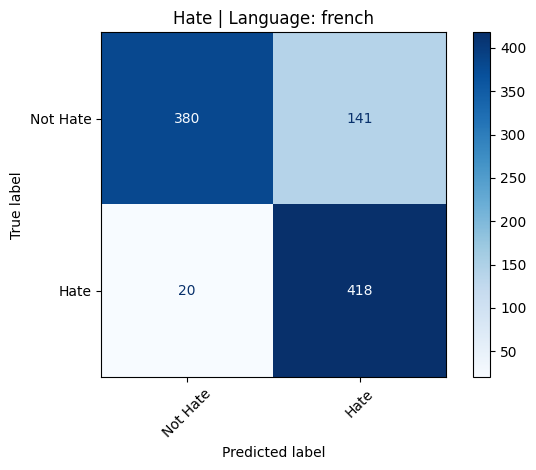

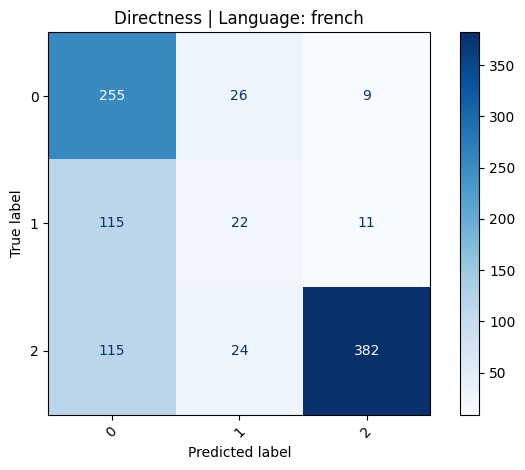

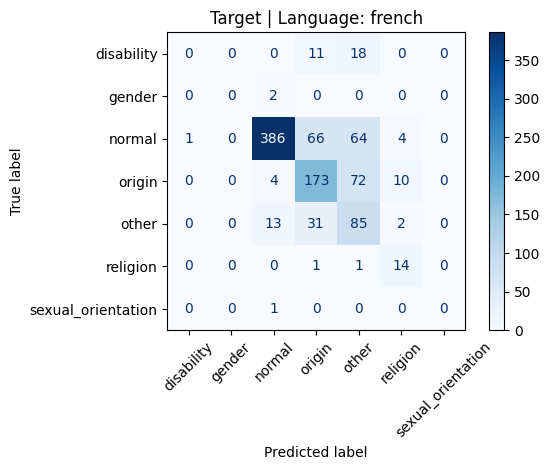

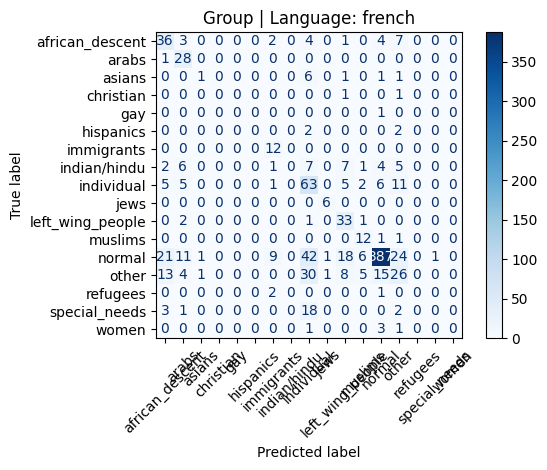

⚠️ Sentiment shape mismatch for language french. Got (959, 0) vs (959, 8). Skipping sentiment confusion matrices.

📘 Language: arabic (encoded: 2)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


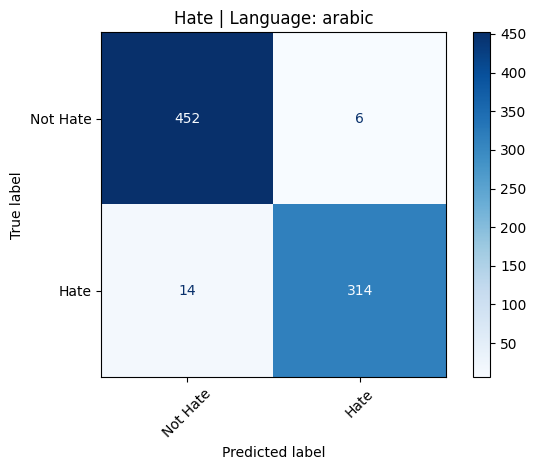

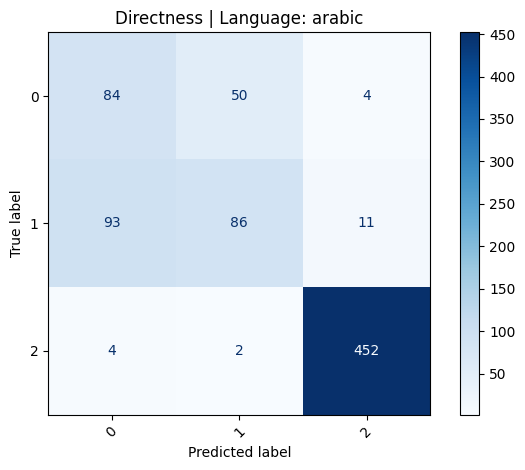

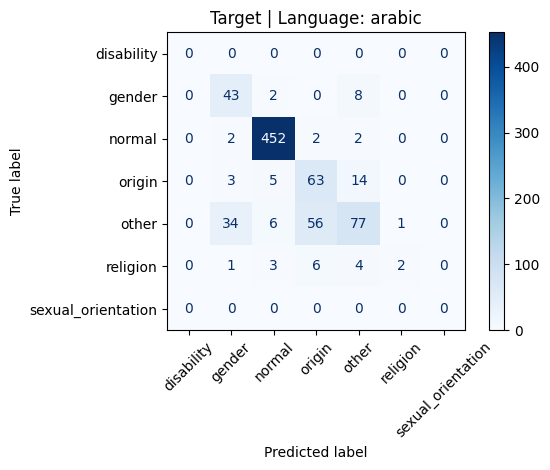

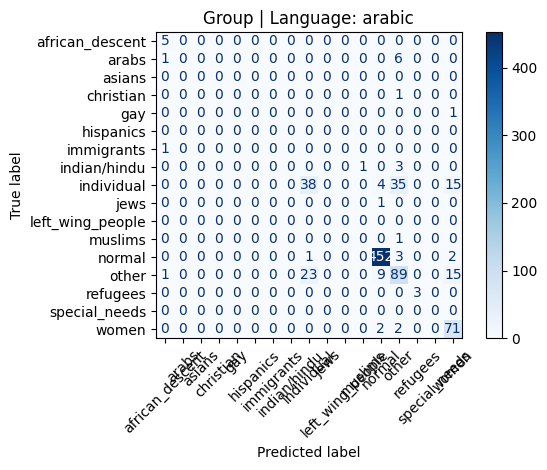

⚠️ Sentiment shape mismatch for language arabic. Got (786, 0) vs (786, 8). Skipping sentiment confusion matrices.

📘 Language: english (encoded: 0)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


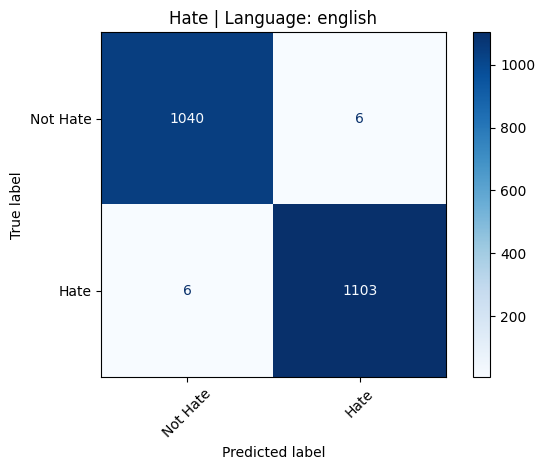

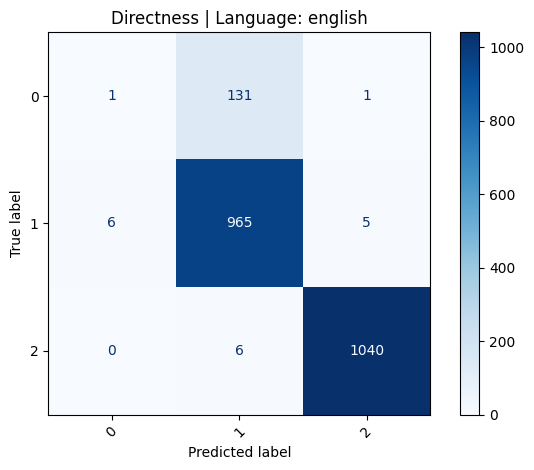

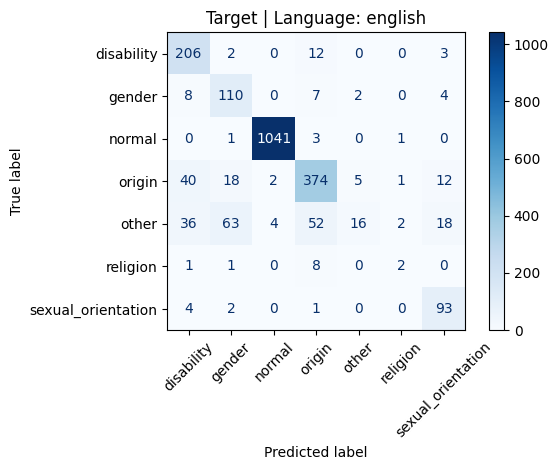

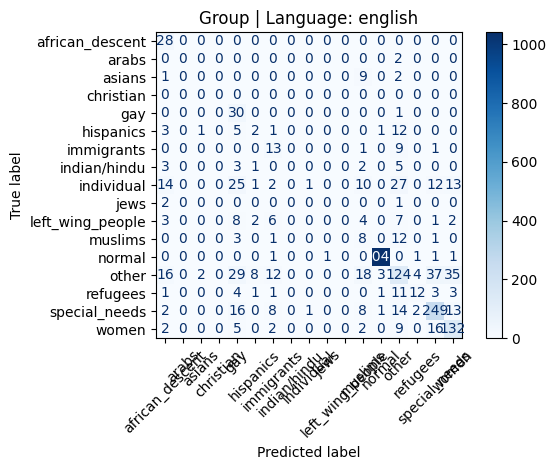

⚠️ Sentiment shape mismatch for language english. Got (2155, 0) vs (2155, 8). Skipping sentiment confusion matrices.


In [ ]:
generate_confusion_matrices_by_language(model, val_df, tokenizer, device)

batch size 64

In [ ]:
train(model, train_loader, val_loader, epochs=3)

Epoch 1/3:   0%|          | 0/480 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 1/3:   0%|          | 1/480 [00:01<10:24,  1.30s/it, loss=5.94]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 1/3:   0%|          | 2/480 [00:02<10:06,  1.27s/it, loss=5.09]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 1/3:   1%|          | 3/480 [00:03<09:58,  1.26s/it, loss=5.39]/u


Epoch 1 Training Loss: 3.1083


Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   2%|▏         | 1/61 [00:00<00:30,  2.00it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   3%|▎         | 2/61 [00:00<00:27,  2.17it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   5%|▍         | 3/61 [00:01<00:26,  2.23it/s]/usr/local/lib/python3.11/dist-pack


HATE (Binary):
  Accuracy: 0.9487179487179487
  Precision (micro): 0.9487179487179487
  Recall (micro): 0.9487179487179487
  F1 Score (micro): 0.9487179487179487

DIRECTNESS (Multi-Class):
  Accuracy: 0.8335897435897436
  Precision (micro): 0.8335897435897436
  Recall (micro): 0.8335897435897436
  F1 Score (micro): 0.8335897435897436

TARGET (Multi-Class):
  Accuracy: 0.7882051282051282
  Precision (micro): 0.7882051282051282
  Recall (micro): 0.7882051282051282
  F1 Score (micro): 0.7882051282051282

GROUP (Multi-Class):
  Accuracy: 0.7066666666666667
  Precision (micro): 0.7066666666666667
  Recall (micro): 0.7066666666666667
  F1 Score (micro): 0.7066666666666667

SENTIMENTS (Multi-Label, 8 classes):
  Precision (micro): 0.734130634774609
  Recall (micro): 0.484149855907781
  F1 Score (micro): 0.5834932821497121


Epoch 2/3:   0%|          | 0/480 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 2/3:   0%|          | 1/480 [00:01<10:12,  1.28s/it, loss=2.36]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 2/3:   0%|          | 2/480 [00:02<10:11,  1.28s/it, loss=1.94]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 2/3:   1%|          | 3/480 [00:03<10:10,  1.28s/it, loss=1.89]/u


Epoch 2 Training Loss: 2.1043


Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   2%|▏         | 1/61 [00:00<00:27,  2.17it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   3%|▎         | 2/61 [00:00<00:26,  2.20it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   5%|▍         | 3/61 [00:01<00:26,  2.18it/s]/usr/local/lib/python3.11/dist-pack


HATE (Binary):
  Accuracy: 0.9520512820512821
  Precision (micro): 0.9520512820512821
  Recall (micro): 0.9520512820512821
  F1 Score (micro): 0.9520512820512821

DIRECTNESS (Multi-Class):
  Accuracy: 0.8441025641025641
  Precision (micro): 0.8441025641025641
  Recall (micro): 0.8441025641025641
  F1 Score (micro): 0.8441025641025641

TARGET (Multi-Class):
  Accuracy: 0.7892307692307692
  Precision (micro): 0.7892307692307692
  Recall (micro): 0.7892307692307692
  F1 Score (micro): 0.7892307692307692

GROUP (Multi-Class):
  Accuracy: 0.7274358974358974
  Precision (micro): 0.7274358974358974
  Recall (micro): 0.7274358974358974
  F1 Score (micro): 0.7274358974358974

SENTIMENTS (Multi-Label, 8 classes):
  Precision (micro): 0.7317127071823204
  Recall (micro): 0.5021993022903078
  F1 Score (micro): 0.5956107213527613


Epoch 3/3:   0%|          | 0/480 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 3/3:   0%|          | 1/480 [00:01<10:36,  1.33s/it, loss=2.29]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 3/3:   0%|          | 2/480 [00:02<10:26,  1.31s/it, loss=1.86]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 3/3:   1%|          | 3/480 [00:03<10:13,  1.29s/it, loss=2.17]/u


Epoch 3 Training Loss: 1.8811


Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   2%|▏         | 1/61 [00:00<00:27,  2.17it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   3%|▎         | 2/61 [00:00<00:27,  2.15it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   5%|▍         | 3/61 [00:01<00:26,  2.16it/s]/usr/local/lib/python3.11/dist-pack


HATE (Binary):
  Accuracy: 0.9482051282051283
  Precision (micro): 0.9482051282051283
  Recall (micro): 0.9482051282051283
  F1 Score (micro): 0.9482051282051283

DIRECTNESS (Multi-Class):
  Accuracy: 0.8441025641025641
  Precision (micro): 0.8441025641025641
  Recall (micro): 0.8441025641025641
  F1 Score (micro): 0.8441025641025641

TARGET (Multi-Class):
  Accuracy: 0.7982051282051282
  Precision (micro): 0.7982051282051282
  Recall (micro): 0.7982051282051282
  F1 Score (micro): 0.7982051282051282

GROUP (Multi-Class):
  Accuracy: 0.7366666666666667
  Precision (micro): 0.7366666666666667
  Recall (micro): 0.7366666666666667
  F1 Score (micro): 0.7366666666666667

SENTIMENTS (Multi-Label, 8 classes):
  Precision (micro): 0.726764645001035
  Recall (micro): 0.5325345062945548
  F1 Score (micro): 0.614670868347339


In [ ]:
train(model, train_loader, val_loader, epochs=3)

Epoch 1/3: 100%|██████████| 480/480 [10:55<00:00,  1.37s/it, loss=1.68]



Epoch 1 Training Loss: 2.1268


Evaluating: 100%|██████████| 61/61 [00:26<00:00,  2.26it/s]



HATE (Binary):
  Accuracy: 0.9525641025641025
  Precision (micro): 0.9525641025641025
  Recall (micro): 0.9525641025641025
  F1 Score (micro): 0.9525641025641025

DIRECTNESS (Multi-Class):
  Accuracy: 0.84
  Precision (micro): 0.84
  Recall (micro): 0.84
  F1 Score (micro): 0.84

TARGET (Multi-Class):
  Accuracy: 0.7941025641025641
  Precision (micro): 0.7941025641025641
  Recall (micro): 0.7941025641025641
  F1 Score (micro): 0.7941025641025641

GROUP (Multi-Class):
  Accuracy: 0.7266666666666667
  Precision (micro): 0.7266666666666667
  Recall (micro): 0.7266666666666667
  F1 Score (micro): 0.7266666666666667

SENTIMENTS (Multi-Label, 8 classes):
  Precision (micro): 0.6912293314162473
  Recall (micro): 0.5833459730016685
  F1 Score (micro): 0.6327218886238382


Epoch 2/3: 100%|██████████| 480/480 [10:23<00:00,  1.30s/it, loss=2.05]



Epoch 2 Training Loss: 1.9325


Evaluating: 100%|██████████| 61/61 [00:26<00:00,  2.27it/s]



HATE (Binary):
  Accuracy: 0.9482051282051283
  Precision (micro): 0.9482051282051283
  Recall (micro): 0.9482051282051283
  F1 Score (micro): 0.9482051282051283

DIRECTNESS (Multi-Class):
  Accuracy: 0.8397435897435898
  Precision (micro): 0.8397435897435898
  Recall (micro): 0.8397435897435898
  F1 Score (micro): 0.8397435897435898

TARGET (Multi-Class):
  Accuracy: 0.7976923076923077
  Precision (micro): 0.7976923076923077
  Recall (micro): 0.7976923076923077
  F1 Score (micro): 0.7976923076923077

GROUP (Multi-Class):
  Accuracy: 0.7397435897435898
  Precision (micro): 0.7397435897435898
  Recall (micro): 0.7397435897435898
  F1 Score (micro): 0.7397435897435898

SENTIMENTS (Multi-Label, 8 classes):
  Precision (micro): 0.7299207539087599
  Recall (micro): 0.5169118762323677
  F1 Score (micro): 0.6052210974960043


Epoch 3/3: 100%|██████████| 480/480 [10:23<00:00,  1.30s/it, loss=1.6]



Epoch 3 Training Loss: 1.7657


Evaluating: 100%|██████████| 61/61 [00:26<00:00,  2.27it/s]


HATE (Binary):
  Accuracy: 0.9502564102564103
  Precision (micro): 0.9502564102564103
  Recall (micro): 0.9502564102564103
  F1 Score (micro): 0.9502564102564103

DIRECTNESS (Multi-Class):
  Accuracy: 0.8438461538461538
  Precision (micro): 0.8438461538461538
  Recall (micro): 0.8438461538461538
  F1 Score (micro): 0.8438461538461538

TARGET (Multi-Class):
  Accuracy: 0.8058974358974359
  Precision (micro): 0.8058974358974359
  Recall (micro): 0.8058974358974359
  F1 Score (micro): 0.8058974358974359

GROUP (Multi-Class):
  Accuracy: 0.7482051282051282
  Precision (micro): 0.7482051282051282
  Recall (micro): 0.7482051282051282
  F1 Score (micro): 0.7482051282051282

SENTIMENTS (Multi-Label, 8 classes):
  Precision (micro): 0.6939724557324272
  Recall (micro): 0.5885029576823904
  F1 Score (micro): 0.6369008535784636
